# Check the placement of objects in a tray

In this exercise we extend the techniques used in previous examples like the [Measure Boxes example](../measure_boxes/measure_boxes.ipynb). The orthographic projection is used again to achieve an undistorted/unskewed view of the measurement workspace. In the undistorted result we measure the height at predetermined locations to check for the presence of parts in the tray. Next we do a simple template matching to test if the parts are placed correctly in the tray.

![A tray full of goniometers that need to be placed in a specific orientation](./check_trays.jpg "Tray with objects")

## Key Learnings

- Basic camera handling and capture
- Usage of a calibration pattern for setting up a practical workspace coordinate system
- Usage of the 2.5D projections from `RenderPointMap`
- Effective use of thresholding / height maps for presence detection
- Naive template matching for object detection

## Preparations

Before capturing a measurement we need to set up the workspace of the camera. The position in which the camera is mounted does not matter for this example, as long as it is mounted well above the boxes height, so that the top of the box is fully visible. The perspective of the camera is corrected by setting up the workspace coordinate system to be on top of the tray, with the x- and y-axes parallel to the ground/box.
This is done in **NxView** via the *Workspace Calibration* tab using a calibration pattern. Place the calibration pattern on top of the trays lower right corner. Then use the button *Set origin with calibration plate* the set the origin to the current location of the pattern. This step ensures that the workspace coordinate system supports an easy measurement of the tray.

The following image shows the placement of the calibration pattern used to set up the workspace coordinate system.

![The calibration pattern is placed right lower corner on top of the tray.](check_trays_calib.jpg "Calibration pattern on the tray.")

For this example we provide a suitable file camera here: [check_tray_placement.enscam](./check_tray_placement.enscam). Add the file camera to **NxView** by clicking on *Create ... -> File Camera* on the main screen of **NxView**.

## Environment

The example expects a **Python** environment of version 3.10 or greater. The following packages will be used:
- NxLib (`nxlib`)
- Numpy (`np`)
- OpenCV (`cv2`)
- MatPlotLib (`plt`)

The example was tested with NxLib version 4.1.1033.

In [1]:
import nxlib
from nxlib import constants as nxc

import numpy as np
import cv2

import matplotlib.pyplot as plt

## Capture

The process of capturing is exactly the same as in the previous example ([Measure Boxes](../measure_boxes/measure_boxes.ipynb)), except for a few parameters. We use a much smaller *PixelSize* for more fidelity and to crop the image appropriately. Also, we translate the camera by 100mm on the x-axis to center the view on the tray.

Open the camera via NxLib and capture a measurement using the usual command chain (`capture() -> rectify() -> compute_disparity_map() -> compute_point_map()`). Except, in this example we use the capture command instead of the `cam.capture()` method. This is necessary since we want to be able to access specific captures from the file camera. We achieve this via the *ImageSet* parameter. Now, since all the data has been captured, we use the `CMD_RENDER_POINT_MAP` command to receive a orthographic view on the scene. The workspace coordinate system is set up parallel to the measurement workspace, thus we receive a top-down perspective of the scene that is perpendicular to the measurement plane.

With the parameters we set up the command to project/rectify the point map to our likings. With the *ViewPose* parameters (all zeros) we place the new virtual camera position to be straight above the workspace origin, set by the calibration pattern target. The parameter *Size* defines the output image size. Since the projected point map is rendered in an orthographic projection (similar to telecentric imaging), the parameter *PixelSize* can be used as a magnification scale. These two parameters define the field of view and scaling of the scene and may need tuning, depending on your setup.

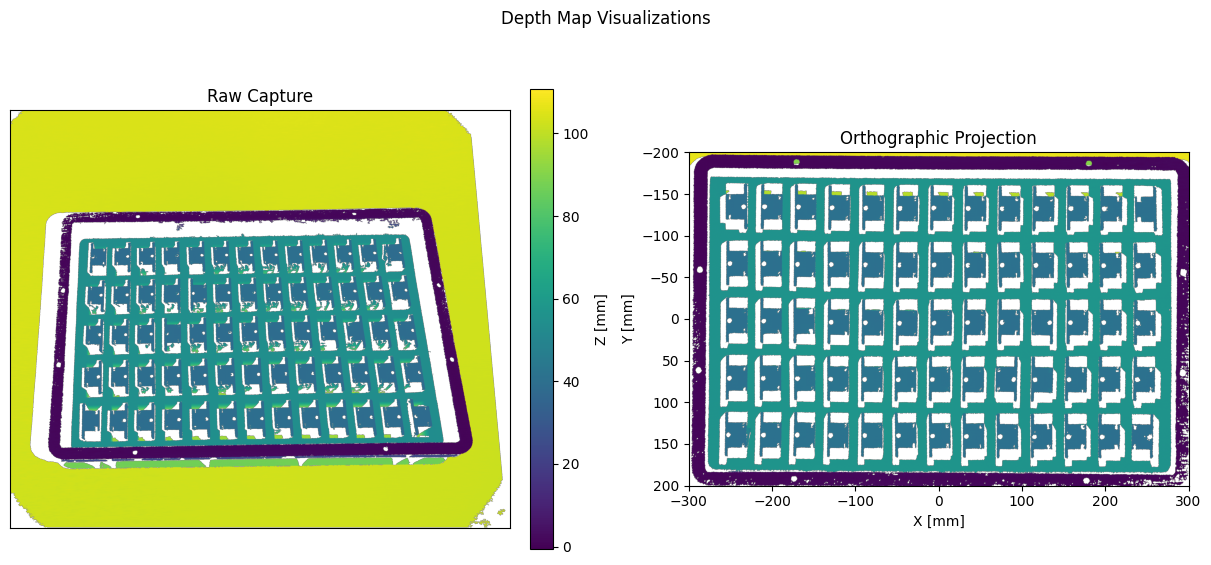

In [2]:
CAM_SERIAL = "check_tray_placement_v3"
IMG_SIZE = [3000, 2000]
PIXEL_SIZE_MM = 0.2
IMAGE_SET = 9


def capture_and_project(image_set: int = 0) -> (np.ndarray, np.ndarray):
    # Open NxLib and a camera using the same context
    with nxlib.NxLib(), nxlib.Camera.from_serial(CAM_SERIAL, [nxc.VAL_STRUCTURED_LIGHT, nxc.VAL_STEREO]) as cam:
        # Capture image
        with nxlib.NxLibCommand(nxc.CMD_CAPTURE, params={"ImageSet": image_set}) as cmd:
            cmd.execute()
        cam.rectify()
        cam.compute_disparity_map()
        cam.compute_point_map()
        point_map = cam.get_point_map()  # not really necessary here, just for comparison

        # Run RenderPointMap command to calculate the rectified/projected point map
        params = {
            "PixelSize": PIXEL_SIZE_MM,
            "Size": IMG_SIZE,
            "ViewPose": {
                "Rotation": {
                    "Angle": 0,
                    "Axis": [0, 0, 0]
                },
                "Translation": [100, 0, 0]
            }
        }

        with nxlib.NxLibCommand(nxc.CMD_RENDER_POINT_MAP, params=params) as cmd:
            cmd.execute()
            point_map_p = cmd.result()["Images"]["RenderPointMap"].get_binary_data()
            texture_p = cmd.result()["Images"]["RenderPointMapTexture"].get_binary_data()[:, :, :3]
            texture_p = np.ascontiguousarray(texture_p)

            return point_map_p, texture_p, point_map

projected_point_map, projected_texture, regular_point_map = capture_and_project(IMAGE_SET)

# --- PLOTS -------------------------------------------------------------------------------------------------

# Image dimensions
h1, w1 = regular_point_map.shape[:2]
h2, w2 = projected_point_map.shape[:2]

# Coordinate axes in mm
x1 = np.linspace(-w1 / 2 * PIXEL_SIZE_MM, w1 / 2 * PIXEL_SIZE_MM, w1)
y1 = np.linspace(-h1 / 2 * PIXEL_SIZE_MM, h1 / 2 * PIXEL_SIZE_MM, h1)
x2 = np.linspace(-w2 / 2 * PIXEL_SIZE_MM, w2 / 2 * PIXEL_SIZE_MM, w2)
y2 = np.linspace(-h2 / 2 * PIXEL_SIZE_MM, h2 / 2 * PIXEL_SIZE_MM, h2)

# Create figure and subplots
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
fig1.suptitle("Depth Map Visualizations")

# Plot left: Raw Capture
im1 = ax1.imshow(regular_point_map[:, :, 2], extent=[x1[0], x1[-1], y1[-1], y1[0]], cmap='viridis')
ax1.set_title("Raw Capture")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_aspect('equal')
cbar1 = fig1.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Z [mm]')

# Plot right: Orthographic Projection
im2 = ax2.imshow(projected_point_map[:, :, 2], extent=[x2[0], x2[-1], y2[-1], y2[0]], cmap='viridis')
ax2.set_title("Orthographic Projection")
ax2.set_xlabel("X [mm]")
ax2.set_ylabel("Y [mm]")
ax2.set_aspect('equal')

plt.show()

# Preprocessing

The first step for analyzing the objects is actually locate them. Therefore, we perform a targeted segmentation of the object faces within a specific height range using connected components analysis. The goal is to isolate a particular surfaces based on their height in a 2.5D projection and identify relevant regions for further processing or inspection.

First, we construct a height image from the z-channel of the projected point map, replacing invalid values. A binary mask is created to select pixels whose height falls within a defined range, effectively isolating the objects' top surfaces. Connected components analysis is then applied to this binary mask to label distinct regions. To filter out noise or irrelevant areas, only those regions whose pixel area falls within a plausible range (e.g. \~20,000 pixels) are retained. Finally, the detected components are visualized in color, highlighting valid regions and marking invalid ones distinctly for inspection.


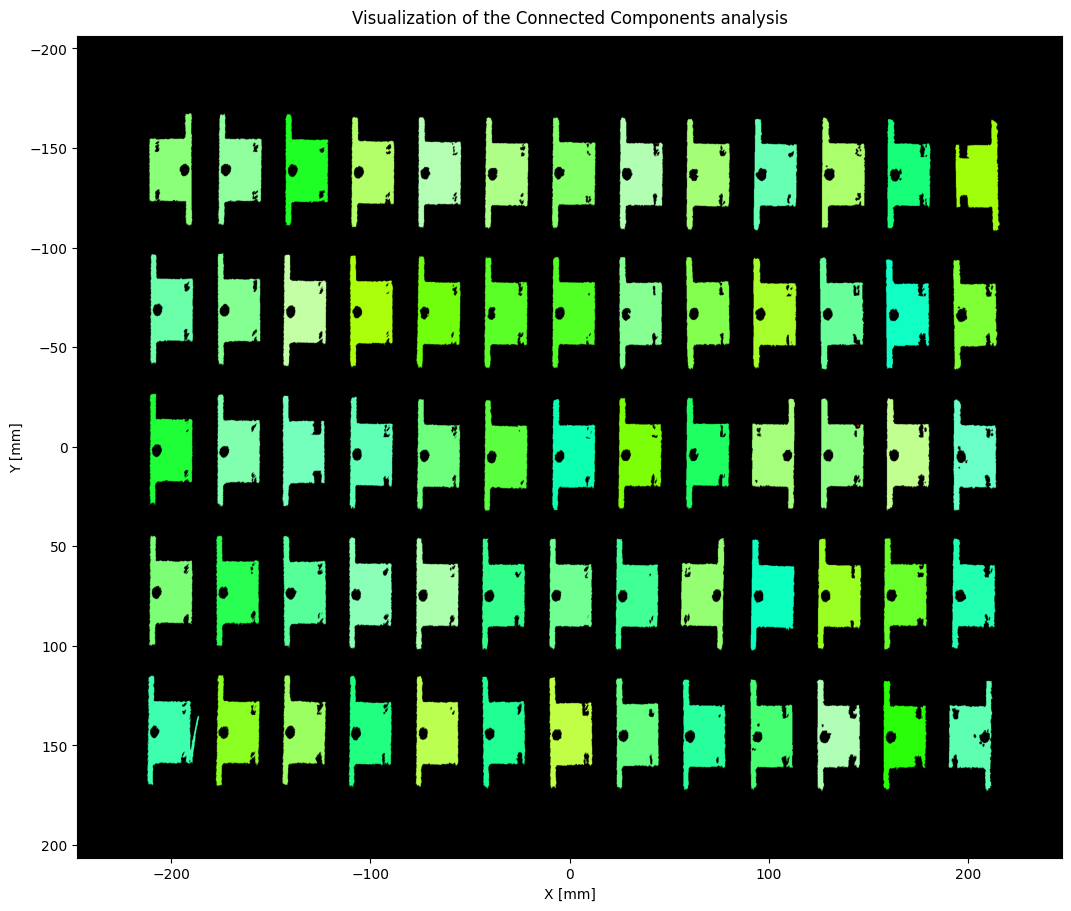

In [3]:
ROI_MIN_HEIGHT_MM = 35
ROI_MAX_HEIGHT_MM = 45

def locate_objects(point_map: np.ndarray) -> (np.ndarray, int, np.ndarray, np.ndarray, np.ndarray):
    # Create height image
    height_image = point_map[:, :, 2]
    height_image[np.isnan(height_image)] = 0

    # Binarize height image to only select the relevant face of the object
    _, height_mask_lower = cv2.threshold(height_image, ROI_MAX_HEIGHT_MM, 1, cv2.THRESH_BINARY_INV)
    _, height_mask_upper = cv2.threshold(height_image, ROI_MIN_HEIGHT_MM, 1, cv2.THRESH_BINARY)
    height_mask = np.asarray(height_mask_lower * height_mask_upper * 255, dtype=np.uint8)

    # Perform connected components (CC) analysis on the binary height mask to locate potential objects
    analysis = cv2.connectedComponentsWithStats(height_mask, 4, cv2.CV_32S)
    (count, ids, values, centroids) = analysis

    # Only select objects with an area within predetermined boundaries (the objects should have ~20.000 pixels)
    indices = np.where(np.bitwise_and((values[:, 4] > 15_000), (values[:, 4] < 25_000)))[0]

    return height_mask, count, ids, centroids, indices

object_mask, label_count, label_ids, label_centroids, valid_indices = locate_objects(projected_point_map)

# --- PLOTS -------------------------------------------------------------------------------------------------

components_viz = np.zeros_like(projected_texture)
for idx in range(1, label_count):
    mask = label_ids == idx
    color = (np.random.randint(200), 255, np.random.randint(200)) if idx in valid_indices else (255, 0, 0)
    components_viz[mask] = color

# Create figure and subplots
fig2, ax3 = plt.subplots(1, 1, figsize=(16, 9), constrained_layout=True)
fig2.suptitle("Visualization of the Connected Components analysis")

# Plot left: Raw Capture
ax3.imshow(components_viz, extent=[x1[0], x1[-1], y1[-1], y1[0]], cmap='viridis')
ax3.set_xlabel("X [mm]")
ax3.set_ylabel("Y [mm]")
ax3.set_aspect('equal')

plt.show()

# Classify objects in the tray

Now we want to check if the objects are placed correctly in the tray slots. We do this using a simple template matching algorithm.

First a predefined binary mask is used as a template to classify detected objects based on their shape. For each connected component from the height mask, template matching is applied to compare the region of interest (ROI) with the object template. A score is calculated based on pixel-wise agreement. Additionally, the presence of a hole — a unique feature of the object only present at the specified location of the part if it is oriented correctly — is verified by checking a subregion of the mask. Objects are marked as valid only if both the overall match and the hole detection exceed specified thresholds. The results are visualized using an overlay on the texture image.


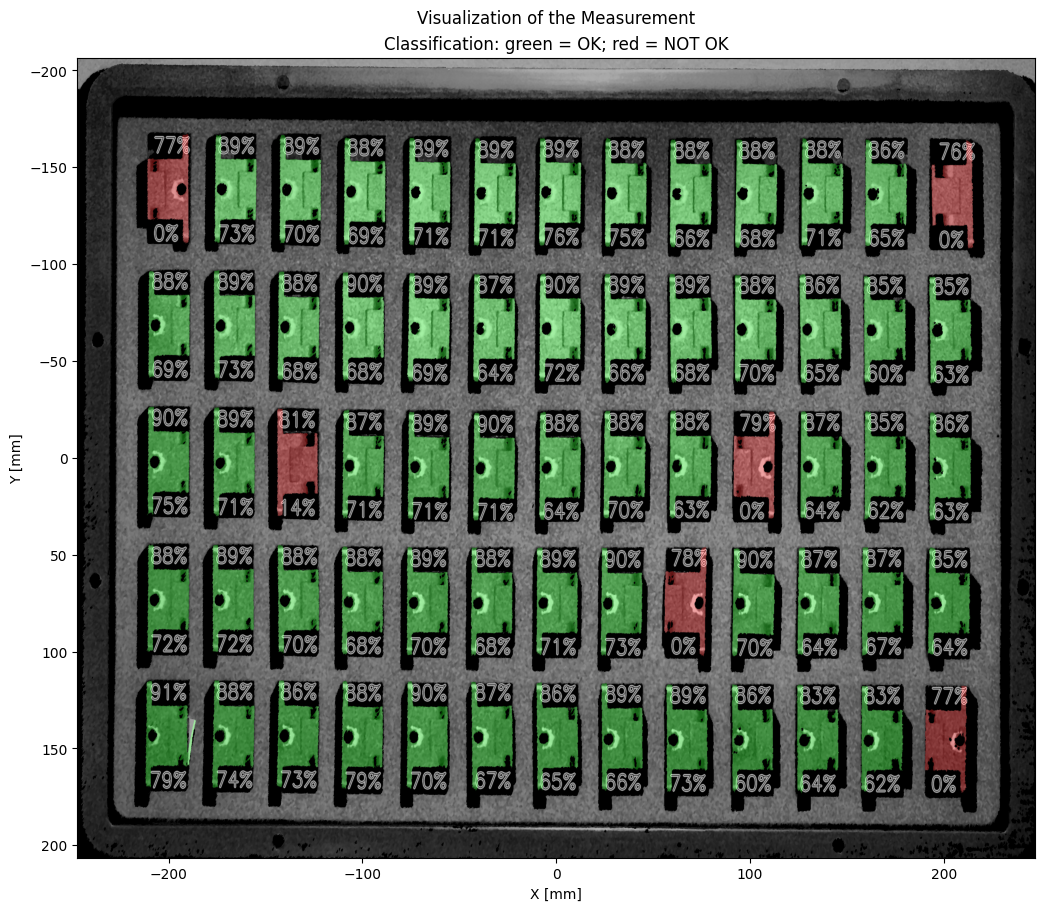

In [4]:
SCORE_THRESHOLD = 0.80
SCORE_THRESHOLD_HOLE = 0.50
TEMPLATE_PATH = "tray_object_mask.png"

def classify_objects(height_mask: np.ndarray, texture: np.ndarray, object_indices: list, object_centroids: np.ndarray, object_ids: np.ndarray, ax: plt.axis = None):
    # Load object template and prepare stuff for template matching
    template = cv2.imread(TEMPLATE_PATH, cv2.IMREAD_GRAYSCALE)
    template = np.asarray(template, dtype=np.uint8)
    template_h, template_w = template.shape
    half_h = template_h // 2
    half_w = template_w // 2
    classification_img = np.copy(texture)
    classification_viz = np.zeros_like(texture)

    # Iterate over all objects from the CC analysis and perform a simple template matching
    for i in object_indices:
        cx, cy = map(int, object_centroids[i])

        # Extract ROI from height_mask
        top = max(cy - half_h, 0)
        left = max(cx - half_w, 0)
        bottom = top + template_h
        right = left + template_w
        roi = height_mask[top:bottom, left:right]

        # Compute matching pixel ratio
        matches = roi == template
        score = np.sum(matches) / template.size

        # Do the same thing to check if the hole is present
        roi_hole = roi[122:152, 7:37]
        template_hole = template[122:152, 7:37]

        # Check if the pixels inside the hole are empty
        matches = roi_hole[template_hole == 0] == 0
        score_hole = np.sum(matches) / np.sum(template_hole == 0)

        # Classify object with thresholds for overall match and the hole
        is_ok = score >= SCORE_THRESHOLD and score_hole >= SCORE_THRESHOLD_HOLE

        # --- PLOTS -------------------------------------------------------------------------------------------------

        # Color mask for this component
        mask_viz = object_ids == i
        object_color = (0, 255, 0) if is_ok else (255, 0, 0)
        classification_viz[mask_viz] = object_color

        # Write scores
        cv2.putText(classification_img, f"{score * 100:.0f}%", (cx - 50, cy - 90), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), thickness=5, lineType=cv2.LINE_AA)
        cv2.putText(classification_img, f"{score * 100:.0f}%", (cx - 50, cy - 90), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
        cv2.putText(classification_img, f"{score_hole * 100:.0f}%", (cx - 50, cy + 130), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (255, 255, 255), thickness=5, lineType=cv2.LINE_AA)
        cv2.putText(classification_img, f"{score_hole * 100:.0f}%", (cx - 50, cy + 130), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)

    # Alpha blend overlay onto projected texture
    alpha = 0.3
    overlay_result = cv2.addWeighted(classification_img, 1 - alpha, classification_viz, alpha, 0)

    # Plot left: Raw Capture
    ax.imshow(overlay_result, extent=[x1[0], x1[-1], y1[-1], y1[0]], cmap='viridis')
    ax.set_title("Classification: green = OK; red = NOT OK")
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    ax.set_aspect('equal')


# Create figure and subplots
fig3, ax4 = plt.subplots(1, 1, figsize=(16, 9), constrained_layout=True)
fig3.suptitle("Visualization of the Measurement")

classify_objects(object_mask, projected_texture, valid_indices, label_centroids, label_ids, ax4)

plt.show()

# Automate it

Finally, we demonstrate the fully composed program to perform the measurement on multiple captures of the *FileCam*. Thereby mimicing a production environment where many trays would be checked for misplaced parts.

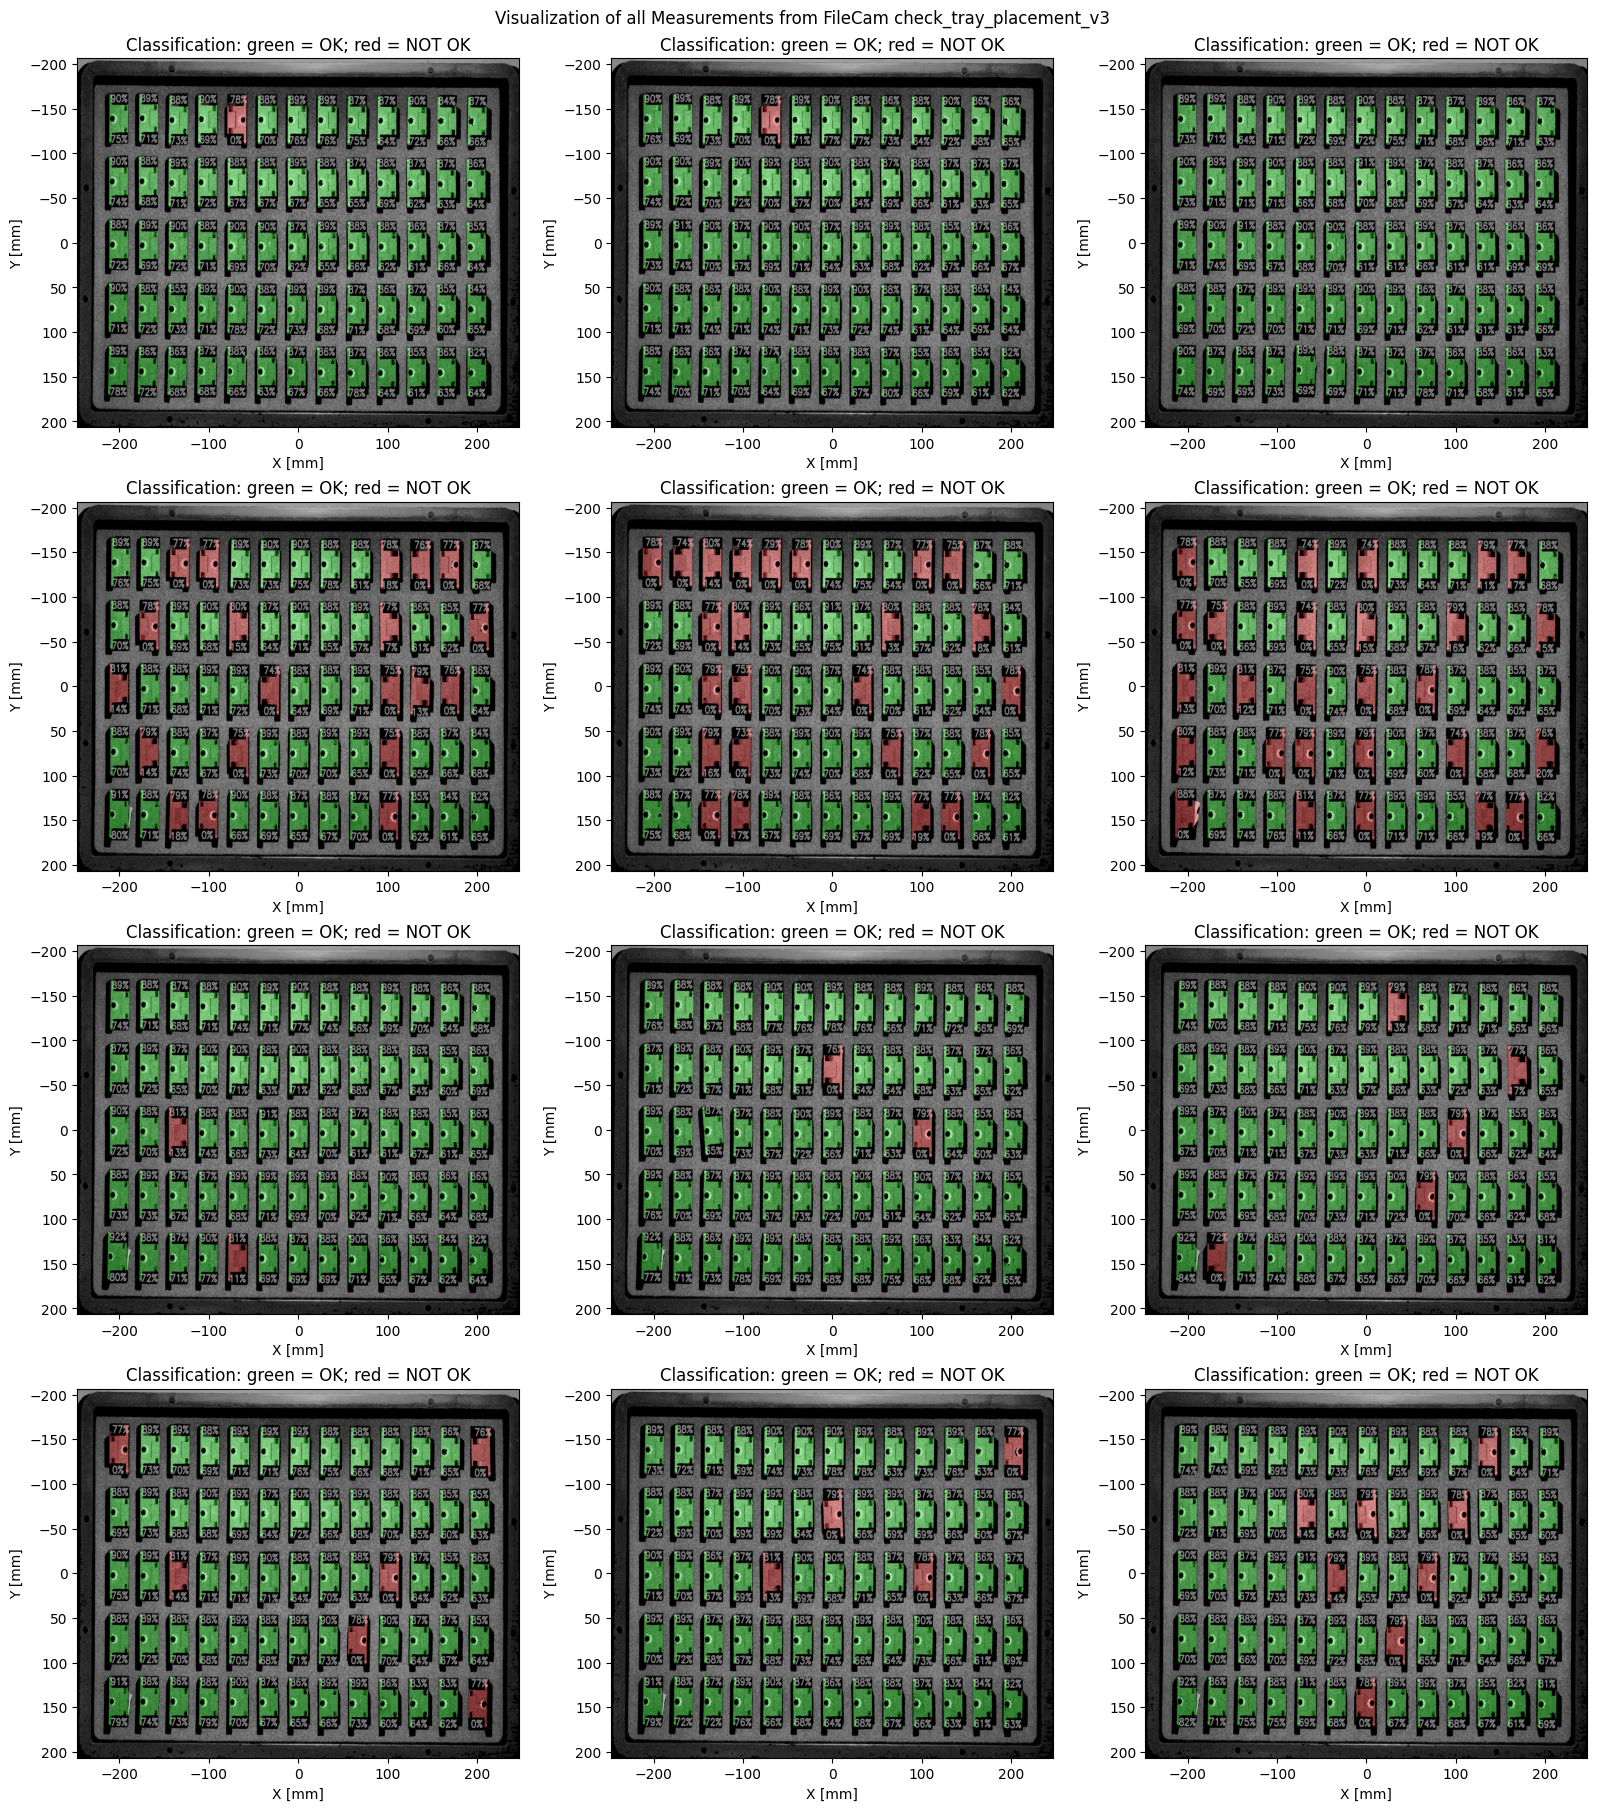

In [5]:
FILECAM_CAPTURE_COUNT = 12
NUM_COLS = 3
num_rows = int(np.ceil(FILECAM_CAPTURE_COUNT / NUM_COLS))
fig_height = 4.5 * num_rows

fig4, axes = plt.subplots(num_rows, NUM_COLS, figsize=(16, fig_height), constrained_layout=True)
fig4.suptitle(f"Visualization of all Measurements from FileCam {CAM_SERIAL}")
axes_list = axes.flatten().tolist()

for idx in range(FILECAM_CAPTURE_COUNT):
    projected_point_map, projected_texture, _ = capture_and_project(idx)
    object_mask, label_count, label_ids, label_centroids, valid_indices = locate_objects(projected_point_map)
    classify_objects(object_mask, projected_texture, valid_indices, label_centroids, label_ids, axes_list[idx])

plt.show()